In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from scipy.constants import pi, c
from scipy.signal import hilbert, find_peaks
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
import matplotlib


In [2]:
plt.rcParams['figure.figsize'] = [10,5]

In [3]:
#Define conversion functions/factors to get to/from meep units and kms
#Length factor to transform lengths in kms
l_unit = 1e-6 #1 um
t_unit = l_unit/c #time unit is length/c

#multiplicative constants to convert frequencies from meep to kms hertz
freq_unit = c/l_unit

print("1 meep Length unit is", l_unit*1e+6, "um")
print("1 meep Time unit is", t_unit*1e+15, "fs")
print("1 meep Frequency unit is", freq_unit*1e-12, "THz")

1 meep Length unit is 1.0 um
1 meep Time unit is 3.3356409519815204 fs
1 meep Frequency unit is 299.792458 THz


# Resolution

In [4]:
#courant factor
S = 0.5

#resolution is number of pixels per meep unit
resolution = 20

#resolutions in meep units
space_res = 1/resolution
time_res = space_res*S

print("Pixel per unit: ", resolution)

print("Space resolution [meep]: ", space_res)
print("Time resolution [meep]: ", time_res)

print("Space resolution [um]: ", space_res*l_unit*1e+6)
print("Time resolution [fs]: ", time_res*t_unit*1e+15)

time_freq = 1/time_res
print("Time sampling frequency [meep]: ", time_freq)
print("Nyqvist frequency [meep]: ", time_freq/2)

Pixel per unit:  20
Space resolution [meep]:  0.05
Time resolution [meep]:  0.025
Space resolution [um]:  0.049999999999999996
Time resolution [fs]:  0.08339102379953803
Time sampling frequency [meep]:  40.0
Nyqvist frequency [meep]:  20.0


# Geometry Definition
Cell

In [5]:
#define cell size and resolution
#Cell size is in meep units
#center is in (0,0), ranges in x=(-sx/2,sx/2), y=(-sy/2,sy/2)
sx = 32
sy = 20

cell = mp.Vector3(sx, sy)

#boundary conditions thickness
pml_thickness = 1.0

#automatic positioning of boundaries
x_bound_up = sx/2 - pml_thickness
x_bound_low = -sx/2 + pml_thickness

y_bound_up = sy/2 - pml_thickness
y_bound_low = -sy/2 + pml_thickness

## Running parameters

In [6]:
distances = np.arange(0.05,0.7,0.05)
loop_f_central_resonance = []

# Resonance Search

Beginning Resonance search
###############
Beginning iteration:  0
Distance:  0.05
Resonance frequency:  0.12974983277591973
###############
Beginning iteration:  1
Distance:  0.1
Resonance frequency:  0.12978327759197325
###############
Beginning iteration:  2
Distance:  0.15000000000000002
Resonance frequency:  0.12978327759197325
###############
Beginning iteration:  3
Distance:  0.2
Resonance frequency:  0.12978327759197325
###############
Beginning iteration:  4
Distance:  0.25
Resonance frequency:  0.12981672240802675
###############
Beginning iteration:  5
Distance:  0.3
Resonance frequency:  0.12981672240802675
###############
Beginning iteration:  6
Distance:  0.35000000000000003
Resonance frequency:  0.12985016722408027
###############
Beginning iteration:  7
Distance:  0.4
Resonance frequency:  0.12988361204013377
###############
Beginning iteration:  8
Distance:  0.45
Resonance frequency:  0.1299170568561873
###############
Beginning iteration:  9
Distance:  0.5
Resonance f

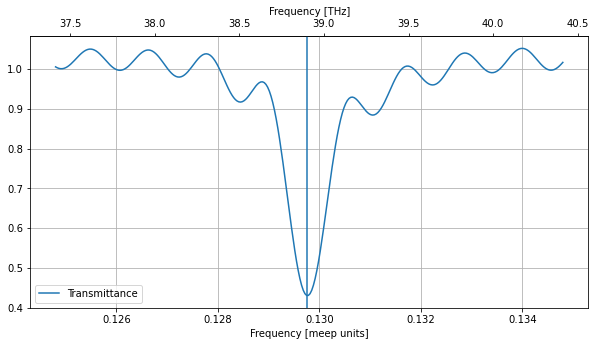

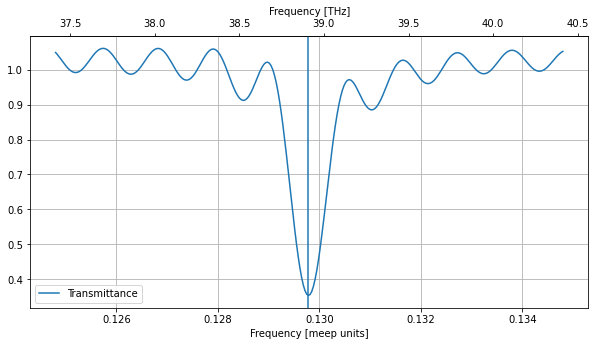

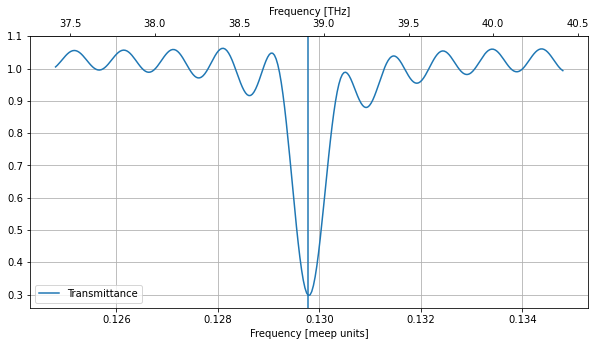

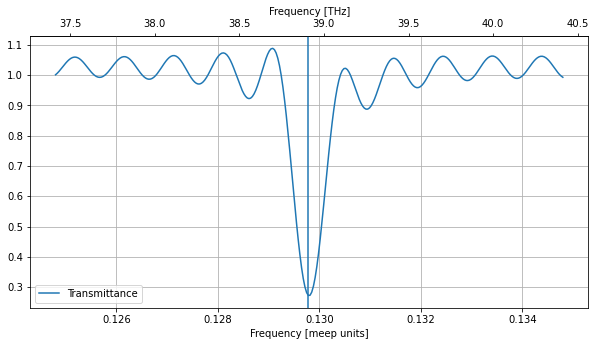

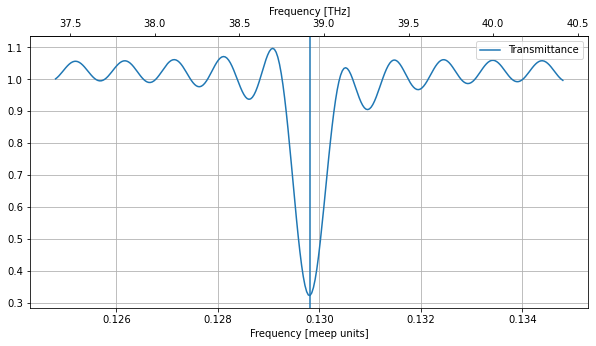

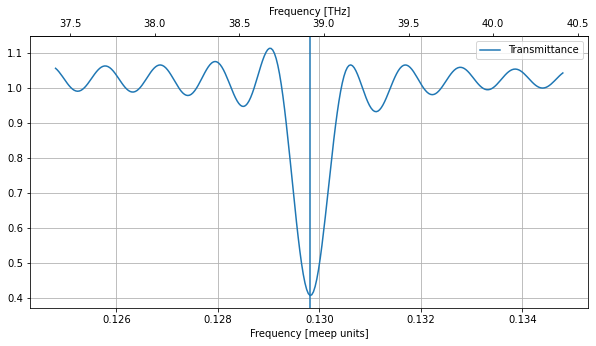

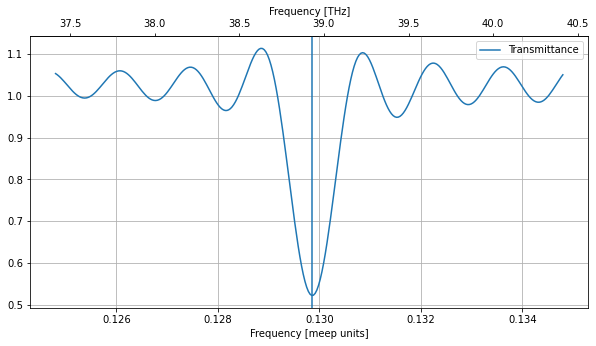

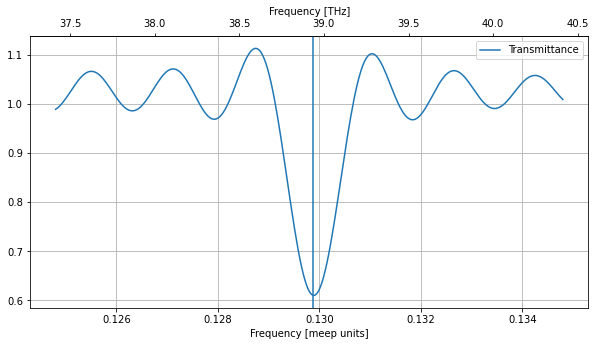

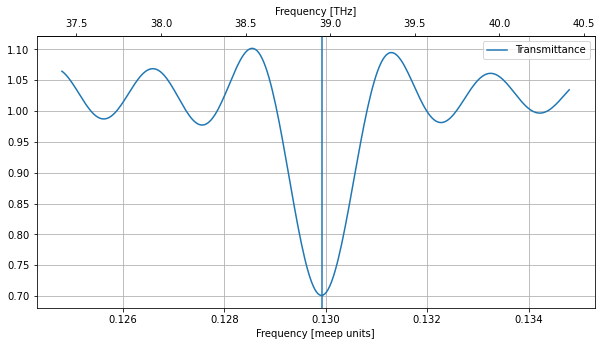

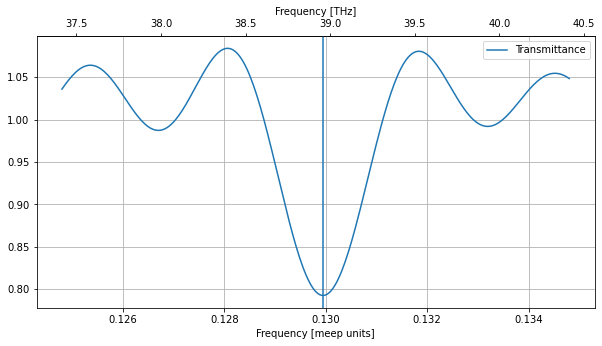

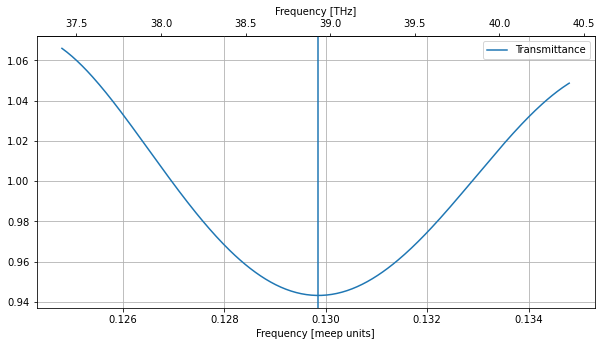

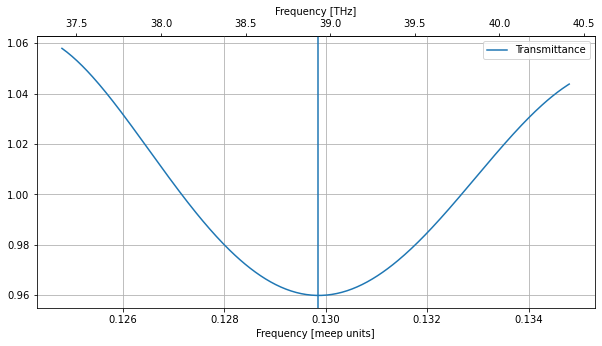

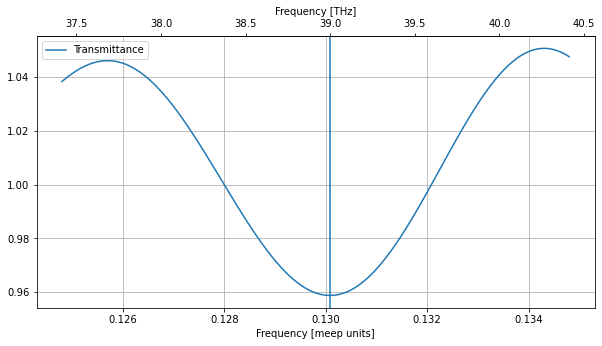

In [7]:
print("Beginning Resonance search")

for index,d in enumerate(distances):
    #Geometry objects
    print("###############")
    print("Beginning iteration: ",index)
    print("Distance: ",d)

    #materials refractive indexes
    n_bgnd = 1
    n_wvg = 3.55
    n_ring = n_wvg

    #Width properties
    wvg_width = 1.6

    ring_r = 3
    ring_w = wvg_width

    #Position properties
    wvg_x = 0
    wvg_y = -(wvg_width + d + ring_w*2 + ring_r*2)/2 + wvg_width/2

    ring_x = 0
    ring_y = wvg_y + wvg_width/2 + d + ring_w + ring_r

    #Soure parameters
    source_x = x_bound_low + 1
    source_y = wvg_y

    source_width = wvg_width

    #Resonance values
    f_central_guess = 0.1298
    df_guess = 0.01
    #central frequency
    f_mon = f_central_guess
    #width of sampled frequency band
    df_mon = df_guess

    #Monitor parameters
    #input
    mon_1_x = source_x + 0.5
    mon_1_y = wvg_y
    mon_1_width = wvg_width

    #output
    mon_2_x = x_bound_up - 1
    mon_2_y = wvg_y
    mon_2_width = wvg_width

    #number of sampling points in frequency for fourier transform of fields accumulated
    N_freq = 300

    check_pt = mp.Vector3(mon_2_x - 0.1, mon_2_y)
    
    waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf),
                    center = mp.Vector3(wvg_x, wvg_y),
                    material = mp.Medium(index=n_wvg))
    ext_ring = mp.Cylinder(radius=ring_r+ring_w,
                    center=mp.Vector3(ring_x, ring_y),
                    material = mp.Medium(index=n_ring))
    int_ring = mp.Cylinder(radius=ring_r,
                    center=mp.Vector3(ring_x, ring_y))

    geometry = [waveguide,
            ext_ring,
            int_ring]

    #define sources
    #gaussian pulse with f_central and df
    sources = [mp.Source(mp.GaussianSource(frequency=f_central_guess, fwidth=df_guess*3),
                        component=mp.Ez,
                        center=mp.Vector3(source_x, source_y),
                        size=mp.Vector3(0, source_width))]

    #define boundary conditions
    pml_layers = [mp.PML(pml_thickness)]

    #Instance simulation with chosen parameters
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        sources=sources,
                        geometry=geometry,
                        resolution=resolution)

    # Flux Monitor 1
    incident_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, mon_1_y), size=mp.Vector3(0, mon_1_width, 0))
    incident = sim.add_flux(f_mon, df_mon, N_freq, incident_fr)

    # Flux Monitor 2
    tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, mon_2_y), size=mp.Vector3(0,mon_2_width,0))
    tran = sim.add_flux(f_mon, df_mon, N_freq, tran_fr)

    #Simulate
    mp.verbosity(0)
    sim.run( until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, check_pt, 1e-3))

    #Get fluxes from fourier transformed fields transmitted
    norm_tran_flux = mp.get_fluxes(tran)

    #Get fluxes from fourier transformed incident fields
    norm_inc_flux = mp.get_fluxes(incident)

    flux_freqs = mp.get_flux_freqs(tran)

    Tr = np.array(norm_tran_flux)/np.array(norm_inc_flux)
    freq_res_main = flux_freqs[np.argmin(Tr)]

    loop_f_central_resonance = np.append(loop_f_central_resonance, freq_res_main)
    print("Resonance frequency: ", freq_res_main )

    plt.figure()
    plt.plot(flux_freqs, Tr, label="Transmittance")

    plt.xlabel("Frequency [meep units]")

    ax = plt.gca()

    def MU2THz(x):
        return x *freq_unit*1e-12


    def THz2MU(x):
        return x /(freq_unit*1e-12)

    secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
    secax.set_xlabel('Frequency [THz]')

    plt.axvline(freq_res_main)

    plt.legend()
    plt.grid()

    sim.reset_meep()
print(loop_f_central_resonance)

# $\Delta \phi$ calculation

In [8]:
run_time = 500

Delta_Phi_list = []

###############
Beginning iteration:  0
Distance:  0.05
Frequency:  0.12974983277591973


FloatProgress(value=0.0, description='0% done ', max=500.0)

No handles with labels found to put in legend.


(640, 3)
K_init:  2.564565431501835  phi_init: 3.750676943570909
K_fin:  2.5750759459778045  phi_fin: 3.9012400533758225
Delta Phi: 0.1505631098049136 , Degrees:  8.626630742186334
###############
Beginning iteration:  1
Distance:  0.1
Frequency:  0.12978327759197325


FloatProgress(value=0.0, description='0% done ', max=500.0)

No handles with labels found to put in legend.


(640, 2)
K_init:  2.585672966155811  phi_init: 3.8849736336153953
K_fin:  2.564565431501836  phi_fin: 3.8789052151459913
Delta Phi: -0.00606841846940398 , Degrees:  -0.34769476661608695
###############
Beginning iteration:  2
Distance:  0.15000000000000002
Frequency:  0.12978327759197325


FloatProgress(value=0.0, description='0% done ', max=500.0)

No handles with labels found to put in legend.


(640, 3)
K_init:  2.580363576098272  phi_init: 3.8028108223864834
K_fin:  2.559342284071487  phi_fin: 3.963781361363665
Delta Phi: 0.16097053897718183 , Degrees:  9.222932509338634
###############
Beginning iteration:  3
Distance:  0.2
Frequency:  0.12978327759197325


FloatProgress(value=0.0, description='0% done ', max=500.0)

No handles with labels found to put in legend.


(640, 2)
K_init:  2.580363576098272  phi_init: 3.8028108223864834
K_fin:  2.564565431501836  phi_fin: 3.8789052151459913
Delta Phi: 0.07609439275950791 , Degrees:  4.3598875497306535
###############
Beginning iteration:  4
Distance:  0.25
Frequency:  0.12981672240802675


FloatProgress(value=0.0, description='0% done ', max=500.0)

No handles with labels found to put in legend.


(640, 3)
K_init:  2.5803635759474943  phi_init: 3.7383017314745217
K_fin:  2.575075945897994  phi_fin: 3.708109358106979
Delta Phi: -0.030192373367542658 , Degrees:  -1.729895567443383
###############
Beginning iteration:  5
Distance:  0.3
Frequency:  0.12981672240802675


FloatProgress(value=0.0, description='0% done ', max=500.0)

/tmp/ipykernel_4613/4274199149.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
No handles with labels found to put in legend.


(640, 2)
K_init:  2.5803635759474943  phi_init: 3.7383017314745217
K_fin:  2.5645654315018356  phi_fin: 3.7506769435709035
Delta Phi: 0.012375212096381816 , Degrees:  0.7090474237019218
###############
Beginning iteration:  6
Distance:  0.35000000000000003
Frequency:  0.12985016722408027


FloatProgress(value=0.0, description='0% done ', max=500.0)

No handles with labels found to put in legend.


(640, 3)
K_init:  2.5645654315018356  phi_init: 3.4942204004207156
K_fin:  2.575075945565321  phi_fin: 3.57935556433587
Delta Phi: 0.08513516391515452 , Degrees:  4.877885580492816
###############
Beginning iteration:  7
Distance:  0.4
Frequency:  0.12988361204013377


FloatProgress(value=0.0, description='0% done ', max=500.0)

No handles with labels found to put in legend.


(640, 2)
K_init:  2.5645654315018356  phi_init: 3.365992128845626
K_fin:  2.5803635760729984  phi_fin: 3.364149009524896
Delta Phi: -0.0018431193207302243 , Degrees:  -0.105602958216861
###############
Beginning iteration:  8
Distance:  0.45
Frequency:  0.1299170568561873


FloatProgress(value=0.0, description='0% done ', max=500.0)

No handles with labels found to put in legend.


(640, 3)
K_init:  2.5803635760362496  phi_init: 3.4157562853721615
K_fin:  2.580363576132159  phi_fin: 3.2996399195468396
Delta Phi: -0.11611636582532192 , Degrees:  -6.652977694188052
###############
Beginning iteration:  9
Distance:  0.5
Frequency:  0.12995050167224081


FloatProgress(value=0.0, description='0% done ', max=500.0)

No handles with labels found to put in legend.


(640, 2)
K_init:  2.5856729657677264  phi_init: 3.367839036671036
K_fin:  2.5645654315018356  phi_fin: 3.3659921288456225
Delta Phi: -0.001846907825413524 , Degrees:  -0.10582002354587962
###############
Beginning iteration:  10
Distance:  0.55
Frequency:  0.12985016722408027


FloatProgress(value=0.0, description='0% done ', max=500.0)

No handles with labels found to put in legend.


(640, 3)
K_init:  2.5645654315018356  phi_init: 3.4942204004207156
K_fin:  2.564565431501835  phi_fin: 3.6224486719958104
Delta Phi: 0.12822827157509487 , Degrees:  7.346938775510277
###############
Beginning iteration:  11
Distance:  0.6000000000000001
Frequency:  0.12985016722408027


FloatProgress(value=0.0, description='0% done ', max=500.0)

No handles with labels found to put in legend.


(640, 2)
K_init:  2.5645654315018356  phi_init: 3.4942204004207156
K_fin:  2.564565431501835  phi_fin: 3.6224486719958104
Delta Phi: 0.12822827157509487 , Degrees:  7.346938775510277
###############
Beginning iteration:  12
Distance:  0.6500000000000001
Frequency:  0.13008428093645485


FloatProgress(value=0.0, description='0% done ', max=500.0)

No handles with labels found to put in legend.


(640, 3)
K_init:  2.5803635758177434  phi_init: 2.899683568118135
K_fin:  2.580363575791796  phi_fin: 2.8480762973804694
Delta Phi: -0.0516072707376658 , Degrees:  -2.956878805457245


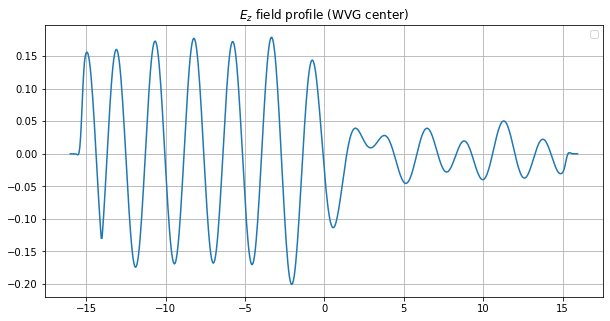

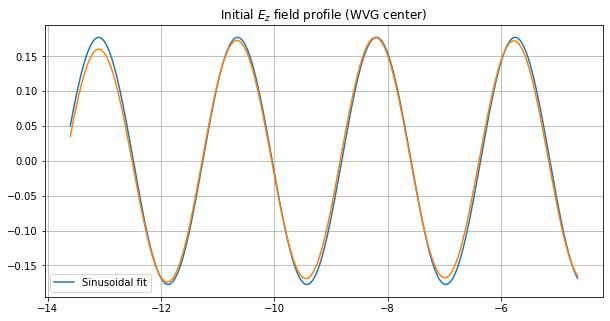

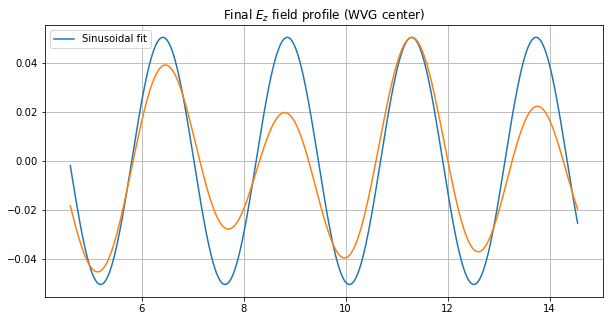

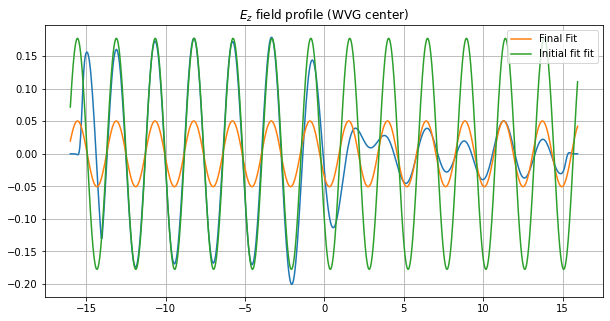

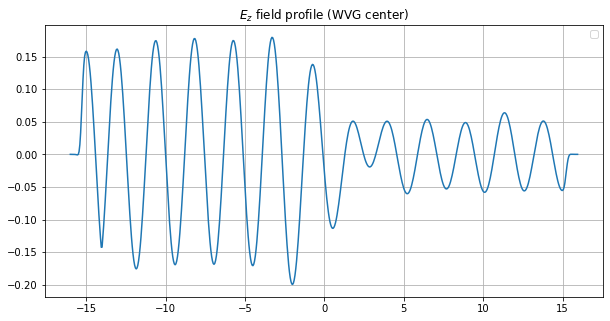

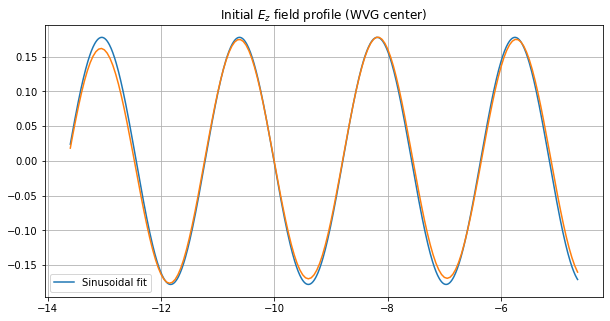

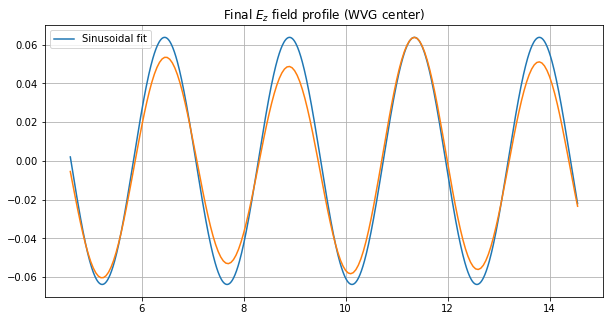

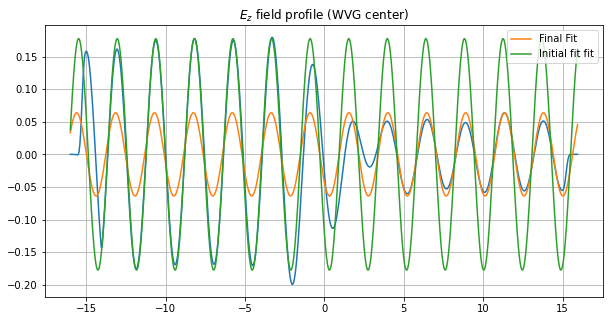

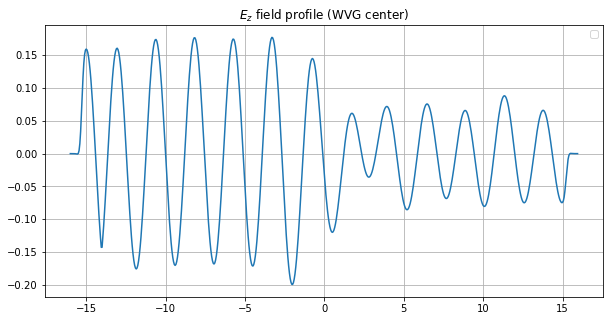

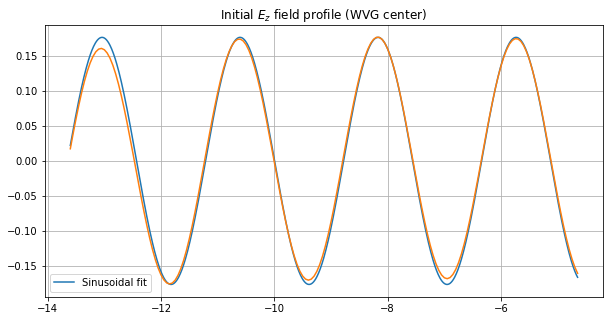

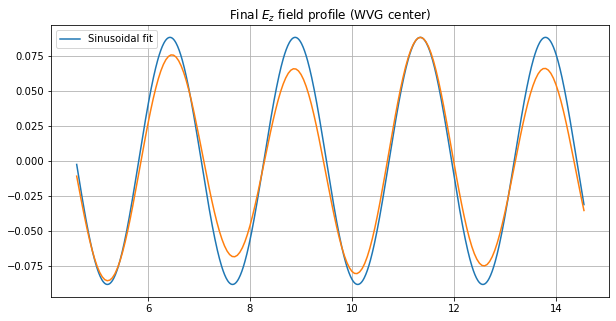

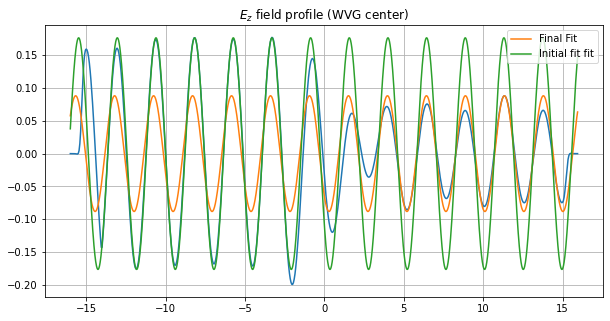

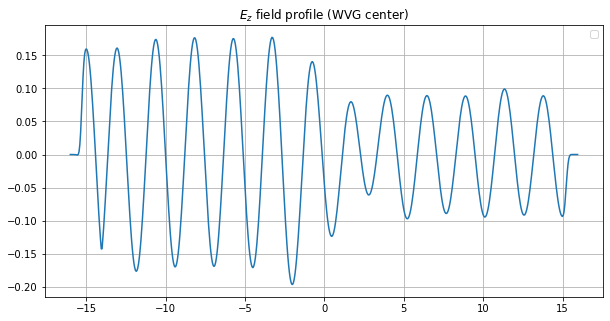

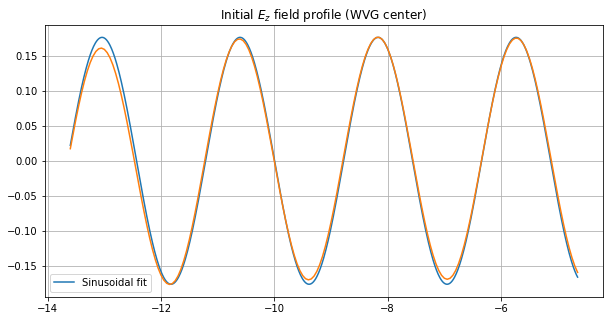

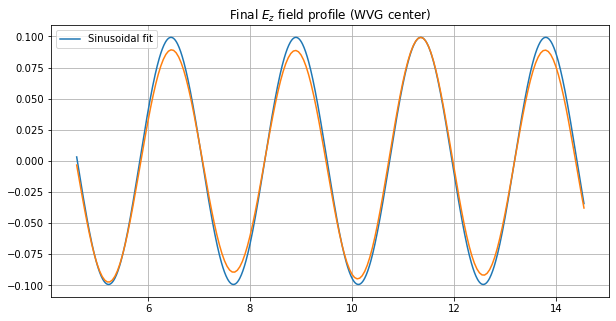

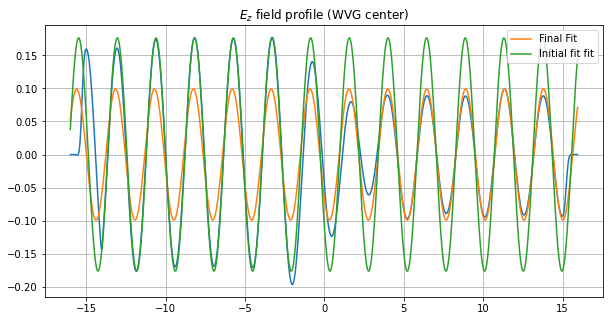

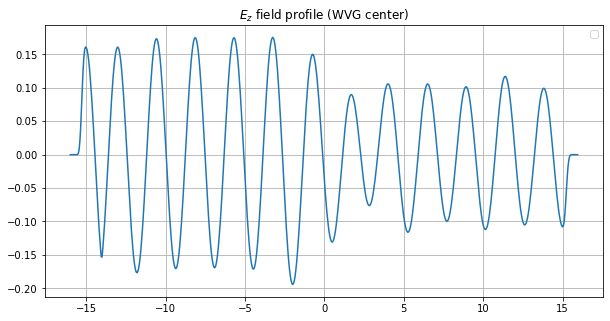

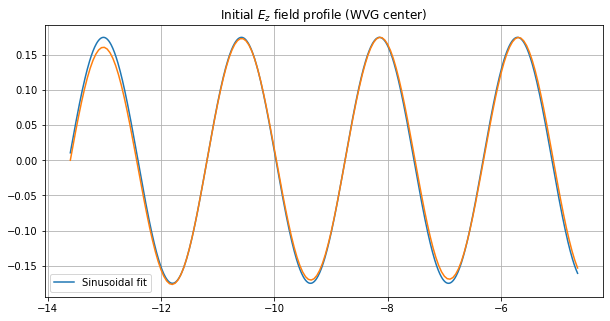

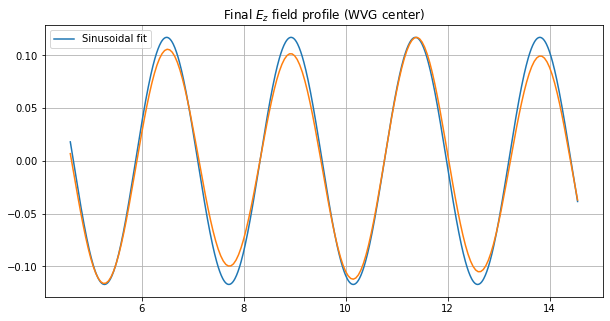

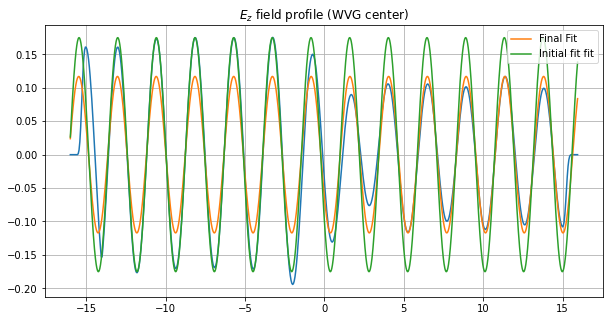

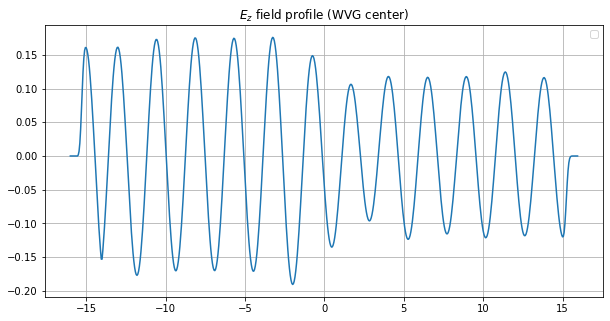

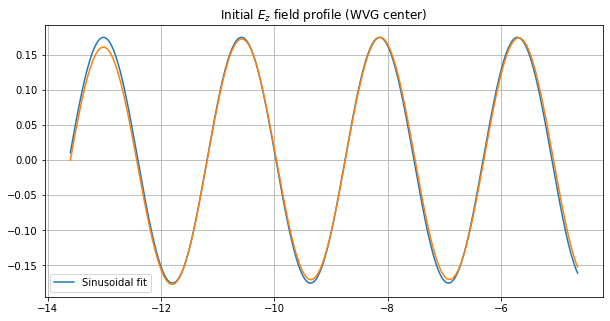

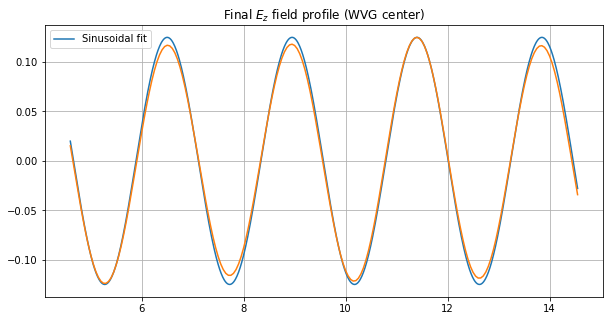

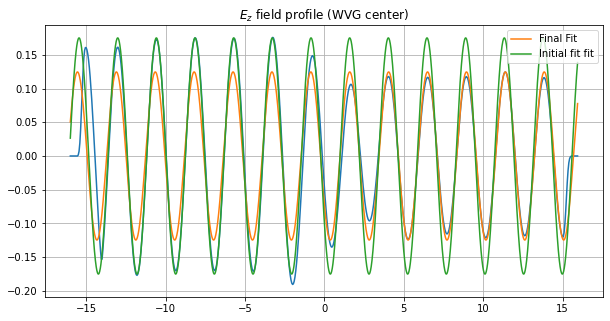

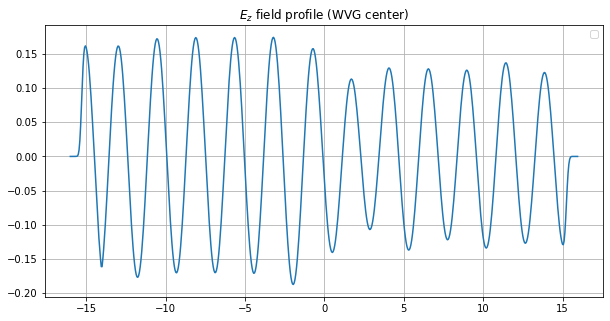

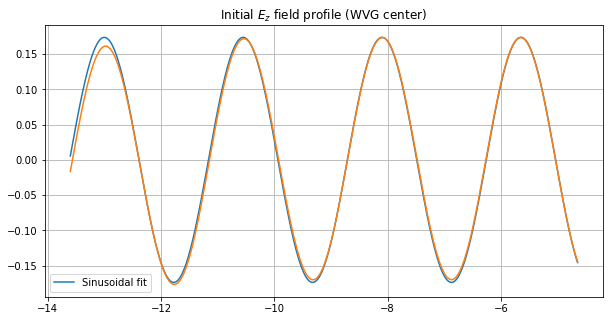

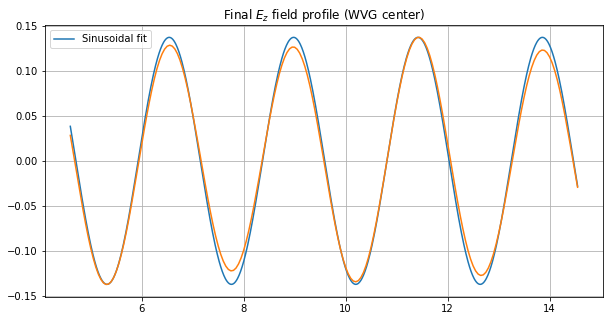

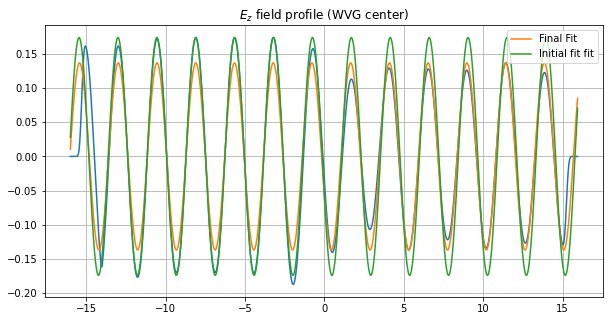

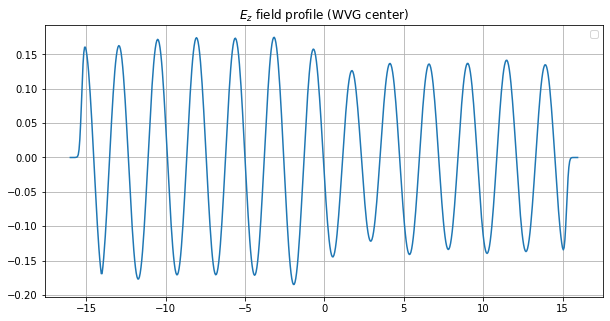

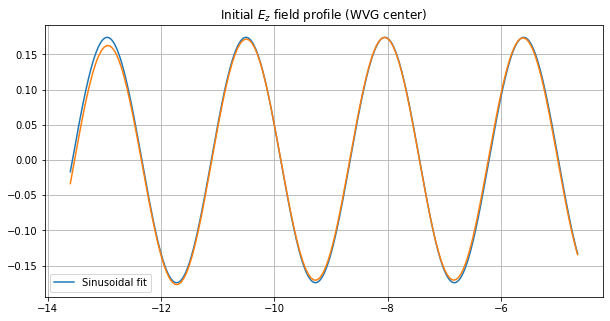

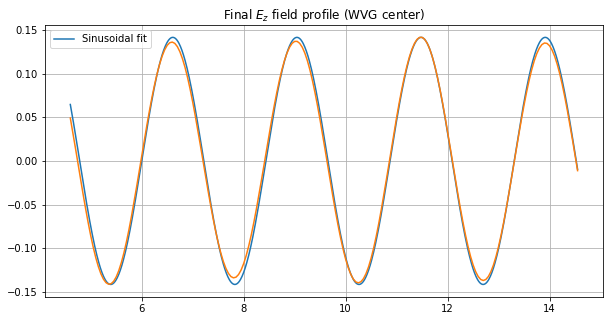

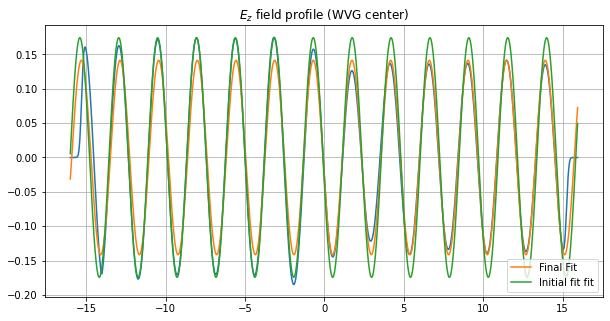

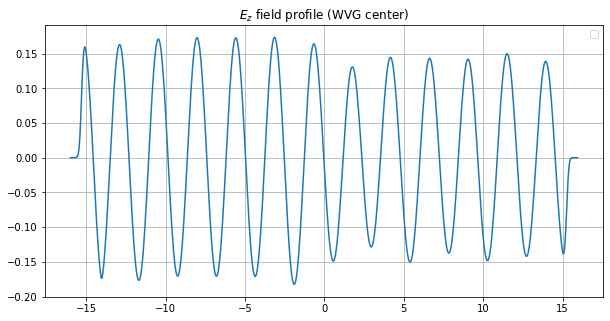

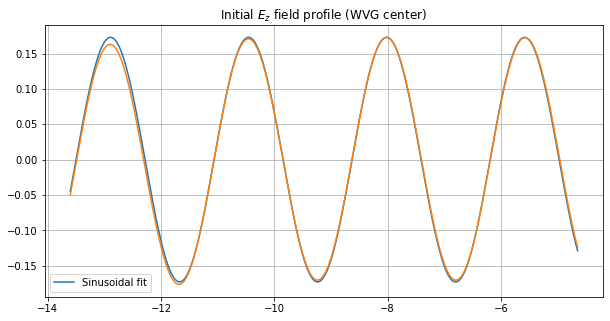

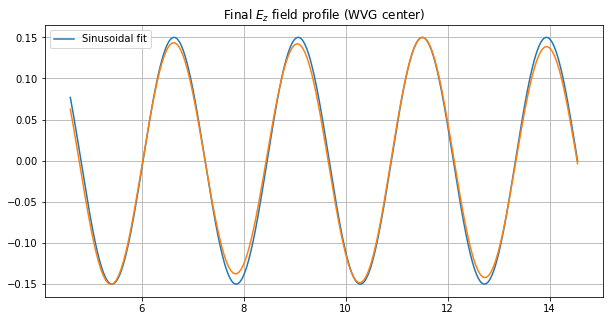

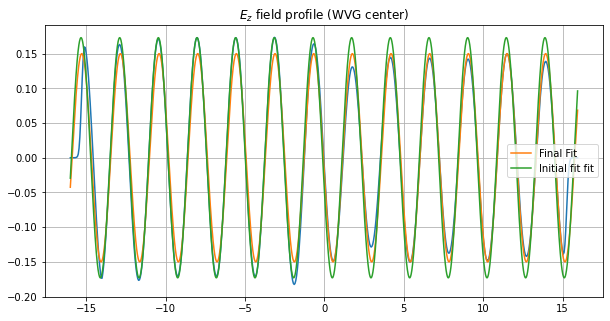

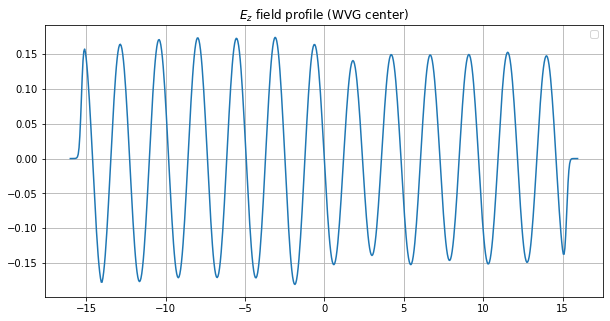

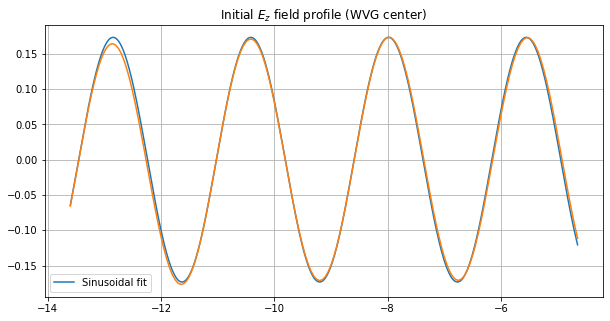

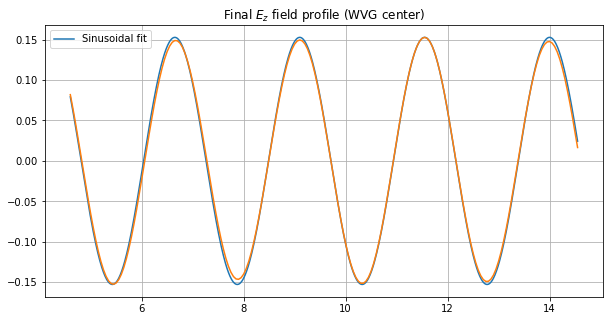

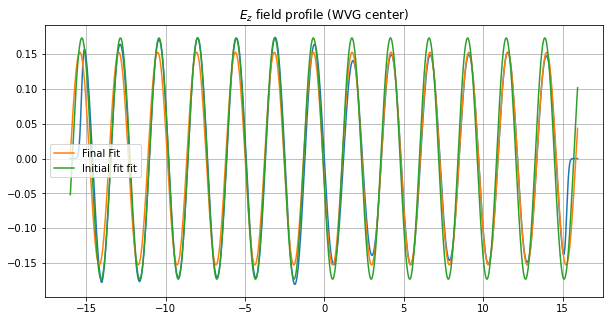

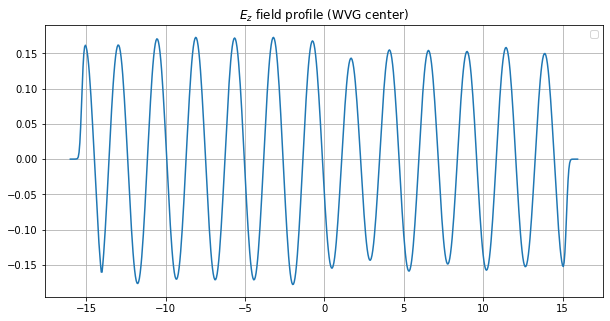

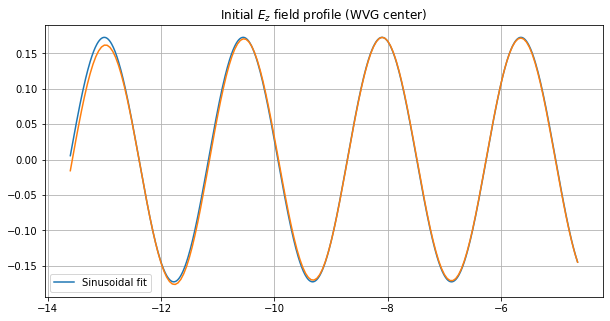

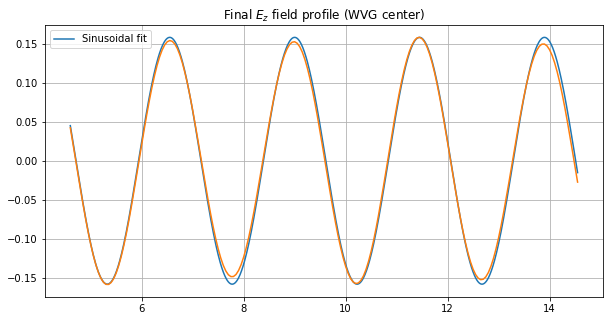

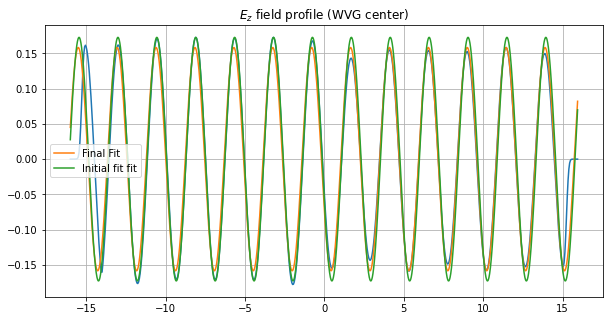

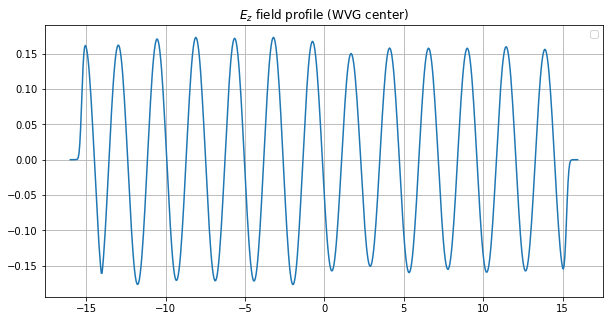

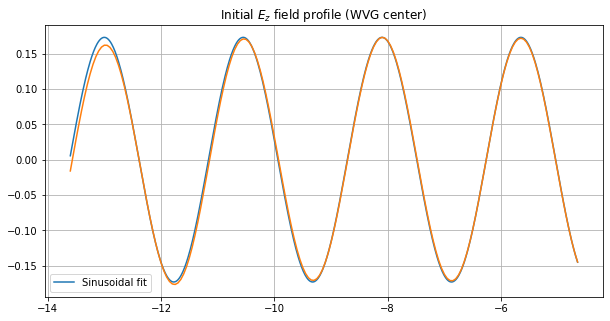

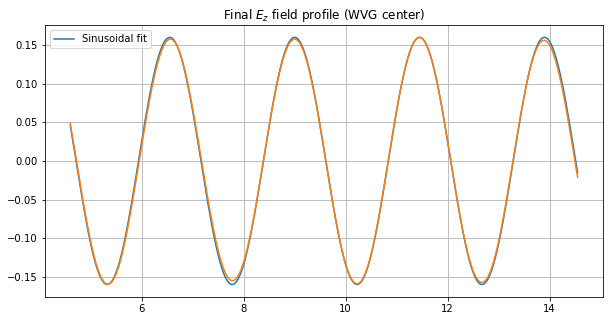

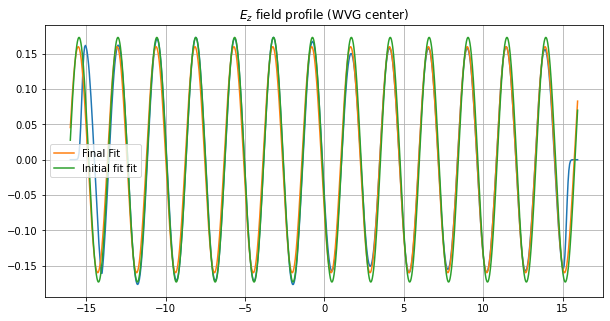

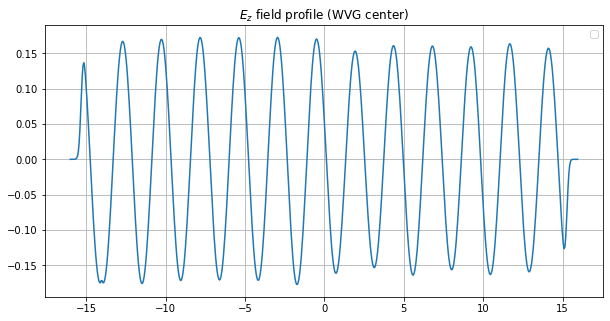

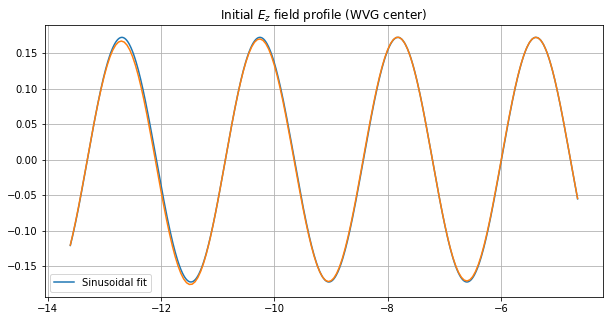

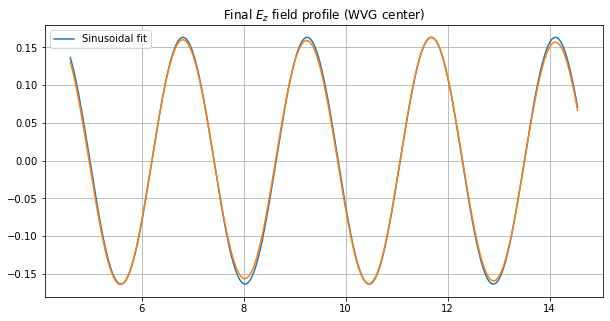

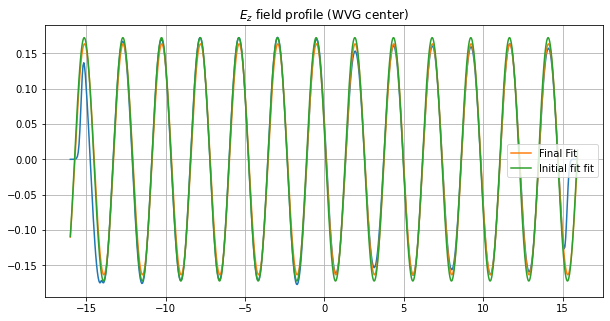

In [10]:
for index,d in enumerate(distances):
    print("###############")
    print("Beginning iteration: ",index)
    print("Distance: ", d)
    print("Frequency: ", loop_f_central_resonance[index])

    #materials refractive indexes
    n_bgnd = 1
    n_wvg = 3.55
    n_ring = n_wvg

    #Width properties
    wvg_width = 1.6

    ring_r = 3
    ring_w = wvg_width

    #Position properties
    wvg_x = 0
    wvg_y = -(wvg_width + d + ring_w*2 + ring_r*2)/2 + wvg_width/2

    ring_x = 0
    ring_y = wvg_y + wvg_width/2 + d + ring_w + ring_r

    #Soure parameters
    source_x = x_bound_low + 1
    source_y = wvg_y

    source_width = wvg_width


    #Geometry objects
    waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf),
                        center = mp.Vector3(wvg_x, wvg_y),
                        material = mp.Medium(index=n_wvg))
    ext_ring = mp.Cylinder(radius=ring_r+ring_w,
                        center=mp.Vector3(ring_x, ring_y),
                        material = mp.Medium(index=n_ring))
    int_ring = mp.Cylinder(radius=ring_r,
                        center=mp.Vector3(ring_x, ring_y))

    geometry = [waveguide,
                ext_ring,
                int_ring]

    #define sources
    #gaussian pulse with f_central and df
    sources = [mp.Source(mp.ContinuousSource(frequency=loop_f_central_resonance[index], width=20),
                        component=mp.Ez,
                        center=mp.Vector3(source_x, source_y),
                        size=mp.Vector3(0, source_width))]

    #define boundary conditions
    pml_layers = [mp.PML(pml_thickness)]

    #Instance simulation with chosen parameters
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        sources=sources,
                        geometry=geometry,
                        resolution=resolution)


    #Simulate
    mp.verbosity(0)
    sim.run(until=run_time)

    ez_data_wvg = sim.get_array(center=mp.Vector3(0,wvg_y), size=mp.Vector3(sx, 0.001), component=mp.Ez)
    print(ez_data_wvg.shape)

    x = np.arange(-sx/2, sx/2, 1/resolution)

    init_mask = (x>(source_x + 0.4))&(x<((-1)*(ring_r+ring_w)))

    init_wave = ez_data_wvg[init_mask][:,0]
    init_x = x[init_mask]


    fin_mask = (x>(ring_r+ring_w))&(x<(x_bound_up-0.4))

    fin_wave = ez_data_wvg[fin_mask][:,0]
    fin_x = x[fin_mask]

    init_peaks, _ = find_peaks(init_wave)
    fin_peaks, _ = find_peaks(fin_wave)

    init_x_peaks = init_x[init_peaks]
    fin_x_peaks = fin_x[fin_peaks]

    def func_linear(m, k, phi):
        return (m*2*pi + pi/2 -phi)/k

    def func_1(x, k, phi):
        return np.amax(init_wave)*np.sin(k*x + phi)

    def func_2(x, k, phi):
        return np.amax(fin_wave)*np.sin(k*x + phi)

    popt_init, pcov_init = curve_fit(func_linear, [i[0] for i in enumerate(init_x_peaks)], init_x_peaks)

    k_fit_init = popt_init[0]
    phi_init = popt_init[1]%(2*pi)

    print("K_init: ",k_fit_init," phi_init:", phi_init)

    popt_fin, pcov_fin = curve_fit(func_linear, [i[0] for i in enumerate(fin_x_peaks)], fin_x_peaks)

    k_fit_fin = popt_fin[0]
    phi_fin = popt_fin[1]%(2*pi)

    print("K_fin: ",k_fit_fin," phi_fin:", phi_fin)


    Delta_Phi = phi_fin - phi_init
    print("Delta Phi:", Delta_Phi, ", Degrees: ",Delta_Phi*360/(2*pi))

    Delta_Phi_list = np.append(Delta_Phi_list, Delta_Phi)
    sim.reset_meep()

    plt.figure()

    plt.plot(x, ez_data_wvg[:,0])

    plt.title(r"$E_z$ field profile (WVG center)")
    plt.legend()
    plt.grid()

    plt.figure()

    dummy_x_init = np.arange(np.amin(init_x), np.amax(init_x), 0.01)

    plt.plot(dummy_x_init, func_1(dummy_x_init, *popt_init), label=r"Sinusoidal fit")
    plt.plot(init_x, init_wave)

    plt.title(r"Initial $E_z$ field profile (WVG center)")
    plt.legend()
    plt.grid()

    plt.figure()

    dummy_x_fin = np.arange(np.amin(fin_x), np.amax(fin_x), 0.01)

    plt.plot(dummy_x_fin, func_2(dummy_x_fin, *popt_fin), label=r"Sinusoidal fit")
    plt.plot(fin_x, fin_wave)

    plt.title(r"Final $E_z$ field profile (WVG center)")
    plt.legend()
    plt.grid()

    plt.figure()

    dummy_x = np.arange(np.amin(x), np.amax(x), 0.01)

    plt.plot(x, ez_data_wvg[:,0])
    plt.plot(dummy_x, func_2(dummy_x, *popt_fin), label=r"Final Fit")
    plt.plot(dummy_x, func_1(dummy_x, *popt_init), label=r"Initial fit fit")


    plt.title(r"$E_z$ field profile (WVG center)")
    plt.legend()
    plt.grid()

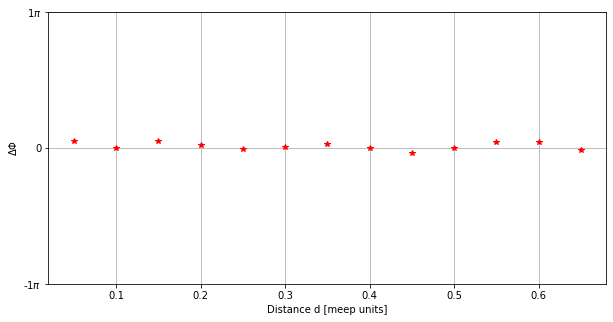

In [11]:


plt.plot(distances, Delta_Phi_list, "r*")

plt.xlabel(r"Distance d [meep units]")
plt.ylabel(r"$\Delta \Phi$")

ax = plt.gca()
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=np.pi))
ax.yaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
plt.ylim(-np.pi,np.pi)

plt.grid()